## Explore Regional Properties

- Select a bounding box, and investigate some SST properties, comparing Stochastic Model Output (with chosen forcing) against CESM.


In [32]:
import numpy as np
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import sys
import cmocean
from tqdm import tqdm
import xarray as xr

#%% Set Paths, Import Custom Modules
stormtrack = 0
if stormtrack == 0:
    projpath   = "/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/"
    datpath     = projpath + '01_Data/model_output/'
    rawpath     = projpath + '01_Data/model_input/'
    outpathdat  = datpath + '/proc/'
    figpath     = projpath + "02_Figures/20211021/"
   
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/03_Scripts/stochmod/model/")
    sys.path.append("/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/")

elif stormtrack == 1:
    datpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_output/"
    rawpath     = "/stormtrack/data3/glliu/01_Data/02_AMV_Project/02_stochmod/Model_Data/model_input/"
    outpathdat  = datpath + '/proc/'
    
    
    sys.path.append("/home/glliu/00_Scripts/01_Projects/00_Commons/")
    sys.path.append("/home/glliu/00_Scripts/01_Projects/01_AMV/02_stochmod/stochmod/model/")

from amv import proc,viz
import scm
import tbx

import importlib
importlib.reload(viz)



<module 'amv.viz' from '/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/00_Commons/03_Scripts/amv/viz.py'>

In [12]:
# User Selections

fname = 'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0'#'forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run009_ampq3',)

In [13]:
%%time
ld = np.load(datpath+"stoch_output_%s.npz"%(fname),allow_pickle=True)
sst = ld["sst"]
lonr = ld['lon']
latr = ld['lat']
sst.shape

CPU times: user 1.24 s, sys: 400 ms, total: 1.64 s
Wall time: 1.64 s


(3, 65, 69, 12000)

In [14]:
# Visualize the variance
sstvar = np.nanvar(sst,-1)

(3, 65, 69, 12000)

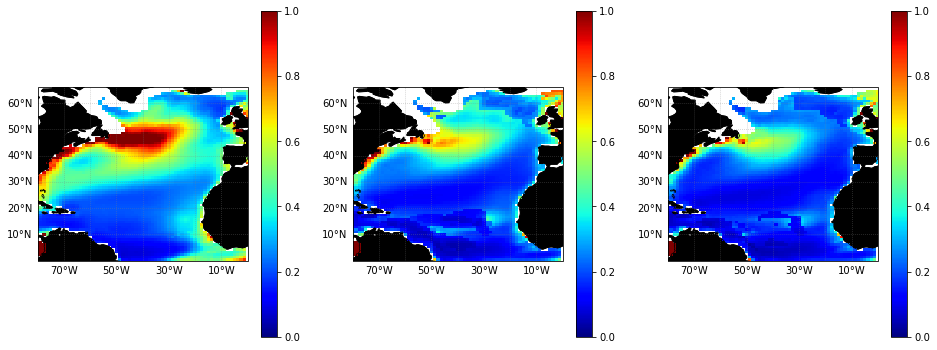

In [31]:
bbox   = [-80,0,0,60] 
fig,axs = viz.init_fig(1,3,figsize=(16,6))


vmin = 0
vmax = 1



for imod in range(3):
    ax = axs.flatten()[imod]
    ax=viz.add_coast_grid(ax,bbox=bbox,fill_color="k")
    pcm = ax.pcolormesh(lonr,latr,sstvar[imod,:,:].T,
                        vmin=vmin,vmax=vmax,cmap='jet')
    fig.colorbar(pcm,ax=ax)

# Convert stochastic model output to an xarray dataset/netCDF

In [33]:
# Convert stochastic model output to an xarray dataset
sstperm = sst.transpose(3,2,1,0) # [time x lat x lon x model]

In [38]:

model = ("h-constant","h-vary","entrain")
times  = np.arange(0,sstperm.shape[0])
sstperm.shape



(12000, 69, 65, 3)

In [61]:
%%time
das = []
for i in range(3):
    da = proc.numpy_to_da(sstperm[...,i],times,latr,lonr,model[i]+"_sst")
    #print(da)
    das.append(da)
das[-1]

CPU times: user 1.17 ms, sys: 4 µs, total: 1.17 ms
Wall time: 1.18 ms


<xarray.DataArray 'entrain_sst' (time: 12000, lat: 69, lon: 65)>
array([[[            nan,             nan,             nan, ...,
          2.79000796e-01,  4.24679796e-01,             nan],
        [            nan,             nan,             nan, ...,
          1.87469574e-01,  1.51682546e-01,             nan],
        [ 3.17703206e+00,  6.07030097e+00,             nan, ...,
          1.80762032e-01,  1.33880194e-01,             nan],
        ...,
        [            nan,             nan,             nan, ...,
          6.64153318e-02,  6.16562926e-02,  5.93496988e-02],
        [            nan,             nan,             nan, ...,
          9.13568101e-02,  8.28216214e-02,  7.43669175e-02],
        [            nan,             nan,             nan, ...,
          1.24673397e-01,  1.13432296e-01,  1.07812737e-01]],

       [[            nan,             nan,             nan, ...,
          5.22695331e-01,  7.68673630e-01,             nan],
        [            nan,             nan,             nan, ...,
          2.50418547e-01,  3.00502795e-01,             nan],
        [ 1.08304874e+00,  2.17844206e+00,             nan, ...,
          2.51011794e-01,  2.70216280e-01,             nan],
...
        [            nan,             nan,             nan, ...,
         -6.50264181e-01, -8.49730761e-01, -1.10177196e+00],
        [            nan,             nan,             nan, ...,
         -7.21536702e-01, -8.55010117e-01, -1.05806195e+00],
        [            nan,             nan,             nan, ...,
         -7.96385115e-01, -8.46302261e-01, -9.60330791e-01]],

       [[            nan,             nan,             nan, ...,
         -1.48114534e+00, -1.20736075e+00,             nan],
        [            nan,             nan,             nan, ...,
         -1.11324427e+00, -6.20265743e-01,             nan],
        [ 1.40343430e+00,  5.01731796e-01,             nan, ...,
         -1.18400990e+00, -9.90893659e-01,             nan],
        ...,
        [            nan,             nan,             nan, ...,
         -2.62329079e-01, -4.84269452e-01, -7.09800399e-01],
        [            nan,             nan,             nan, ...,
         -3.46894030e-01, -4.78347072e-01, -7.20648348e-01],
        [            nan,             nan,             nan, ...,
         -4.01664628e-01, -4.52759099e-01, -6.12886064e-01]]])
Coordinates:
  * time     (time) int64 0 1 2 3 4 5 6 ... 11994 11995 11996 11997 11998 11999
  * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
  * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0

In [62]:
# Merge into dataset
ds = xr.merge(das)
ds

<xarray.Dataset>
Dimensions:         (time: 12000, lat: 69, lon: 65)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 ... 11995 11996 11997 11998 11999
  * lat             (lat) float64 0.4712 1.414 2.356 3.298 ... 62.67 63.61 64.55
  * lon             (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -2.5 -1.25 0.0
Data variables:
    h-constant_sst  (time, lat, lon) float64 nan nan nan ... 0.0905 0.004455
    h-vary_sst      (time, lat, lon) float64 nan nan nan ... -1.591 -1.582
    entrain_sst     (time, lat, lon) float64 nan nan nan ... -0.4528 -0.6129

In [67]:
edict = {vnames[i] + "_sst": {'zlib': True} for i in range(len(model))}
edict

{'h-constant_sst': {'zlib': True},
 'h-vary_sst': {'zlib': True},
 'entrain_sst': {'zlib': True}}

In [68]:
%%time
# Save Dataset
outname = "%sstoch_output_%s.nc" % (datpath,fname)
ds.to_netcdf(outname,
                 encoding=edict)
print(outname)


/Users/gliu/Downloads/02_Research/01_Projects/01_AMV/02_stochmod/01_Data/model_output/stoch_output_forcingflxeof_090pct_SLAB-PIC_eofcorr2_1000yr_run011_ampq3_method4_dmp0.nc
CPU times: user 28.6 s, sys: 508 ms, total: 29.1 s
Wall time: 29.3 s


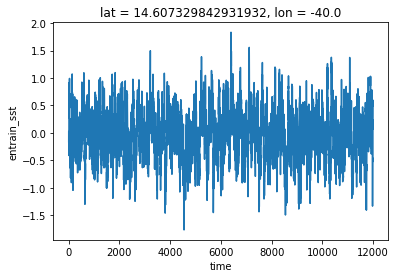

In [50]:
das[2].sel(lon=-40,lat=15,method='nearest').plot()

In [52]:
ds = xr.Dataset(das[0])

TypeError: unhashable type: 'DataArray'

In [53]:
vnames = model

In [54]:


coords = ["time", "lat", "lon"]
pairs  = [(coords,da[i]) for i in range(len(das))]


pairs
#vdict = { key:value for }

[(['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,        nan, ..., 0.2790008 , 0.4246798 ,
                 nan],
         [       nan,        nan,        nan, ..., 0.18746957, 0.15168255,
                 nan],
         [3.17703206, 6.07030097,        nan, ..., 0.18076203, 0.13388019,
                 nan],
         ...,
         [       nan,        nan,        nan, ..., 0.06641533, 0.06165629,
          0.0593497 ],
         [       nan,        nan,        nan, ..., 0.09135681, 0.08282162,
          0.07436692],
         [       nan,        nan,        nan, ..., 0.1246734 , 0.1134323 ,
          0.10781274]])
  Coordinates:
      time     int64 0
    * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
    * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0),
 (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,  

In [56]:
vdict = {vnames[i]:pairs[i] for i in range(len(das)) }
vdict

{'h-constant': (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[       nan,        nan,        nan, ..., 0.2790008 , 0.4246798 ,
                 nan],
         [       nan,        nan,        nan, ..., 0.18746957, 0.15168255,
                 nan],
         [3.17703206, 6.07030097,        nan, ..., 0.18076203, 0.13388019,
                 nan],
         ...,
         [       nan,        nan,        nan, ..., 0.06641533, 0.06165629,
          0.0593497 ],
         [       nan,        nan,        nan, ..., 0.09135681, 0.08282162,
          0.07436692],
         [       nan,        nan,        nan, ..., 0.1246734 , 0.1134323 ,
          0.10781274]])
  Coordinates:
      time     int64 0
    * lat      (lat) float64 0.4712 1.414 2.356 3.298 ... 61.73 62.67 63.61 64.55
    * lon      (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -3.75 -2.5 -1.25 0.0),
 'h-vary': (['time', 'lat', 'lon'],
  <xarray.DataArray 'entrain_sst' (lat: 69, lon: 65)>
  array([[ 

In [58]:
xr.Dataset(vdict)

TypeError: Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

In [59]:
hey = xr.merge(das)
hey

<xarray.Dataset>
Dimensions:         (time: 12000, lat: 69, lon: 65)
Coordinates:
  * time            (time) int64 0 1 2 3 4 5 ... 11995 11996 11997 11998 11999
  * lat             (lat) float64 0.4712 1.414 2.356 3.298 ... 62.67 63.61 64.55
  * lon             (lon) float64 -80.0 -78.75 -77.5 -76.25 ... -2.5 -1.25 0.0
Data variables:
    h-constant_sst  (time, lat, lon) float64 nan nan nan ... 0.0905 0.004455
    h-vary_sst      (time, lat, lon) float64 nan nan nan ... -1.591 -1.582
    entrain_sst     (time, lat, lon) float64 nan nan nan ... -0.4528 -0.6129